# 🎬 Movie Recommendation System

This project builds a **movie recommendation system** using the
**MovieLens 100K dataset**.  

I implemented three different approaches:  
1. **User–User Collaborative Filtering** (similarity-based)  
2. **Matrix Factorization** (latent factor model)  
3. **Neural Network Recommender** (nonlinear embeddings)  

We evaluate models using **RMSE** and **Precision@K**.  


In [13]:
!pip install pandas numpy tensorflow scikit-learn requests matplotlib seaborn

import os, zipfile, random, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


I used the **MovieLens 100K** dataset, which contains:
- 100,000 ratings
- 943 users
- 1,682 movies


In [14]:
def download_and_extract_ml100k(dest_dir="."):
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    zpath = os.path.join(dest_dir, "ml-100k.zip")
    if not os.path.exists(zpath):
        print("Downloading MovieLens 100k...")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(zpath, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    print("Extracting...")
    with zipfile.ZipFile(zpath, "r") as z:
        z.extractall(dest_dir)

    return os.path.join(dest_dir, "ml-100k")

ml_dir = download_and_extract_ml100k()


Extracting...


In [15]:
movies_path = os.path.join(ml_dir, "u.item")
users_path = os.path.join(ml_dir, "u.user")
ratings_path = os.path.join(ml_dir, "u.data")

movie_cols = ['movie_id','title','release_date','video_release_date','IMDb_URL',
              'unknown','action','adventure','animation','childrens','comedy',
              'crime','documentary','drama','fantasy','film_noir','horror',
              'musical','mystery','romance','sci_fi','thriller','war','western']
user_cols = ['user_id','age','gender','occupation','zip_code']
rating_cols = ['user_id','movie_id','rating','timestamp']

movie_df = pd.read_csv(movies_path, sep='|', names=movie_cols, encoding='latin-1')
user_df = pd.read_csv(users_path, sep='|', names=user_cols, encoding='latin-1')
rating_df = pd.read_csv(ratings_path, sep='\t', names=rating_cols, encoding='latin-1')

movie_df['release_date'] = pd.to_datetime(movie_df['release_date'], errors='coerce')

print(movie_df.head())
print(user_df.head())
print(rating_df.head())


   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)   1995-01-01                 NaN   
1         2   GoldenEye (1995)   1995-01-01                 NaN   
2         3  Four Rooms (1995)   1995-01-01                 NaN   
3         4  Get Shorty (1995)   1995-01-01                 NaN   
4         5     Copycat (1995)   1995-01-01                 NaN   

                                            IMDb_URL  unknown  action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   adventure  animation  childrens  ...  fantasy  film_noir  horror  musical  \
0          0          1          1  ...        0          0       0        0  

## 🔎 Exploratory Data Analysis

I first explored:
- Movie release years
- Genre distribution
- User demographics
- Ratings distribution


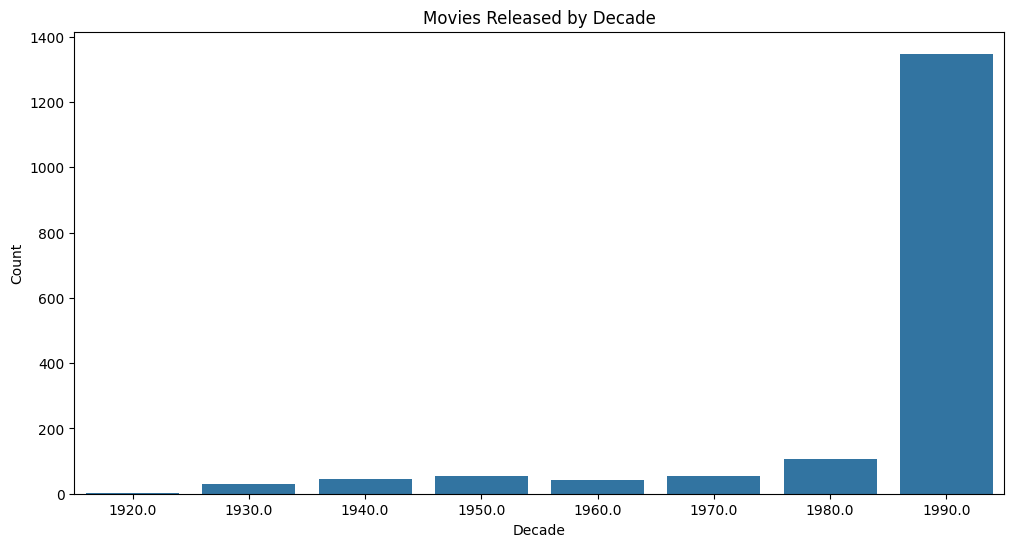

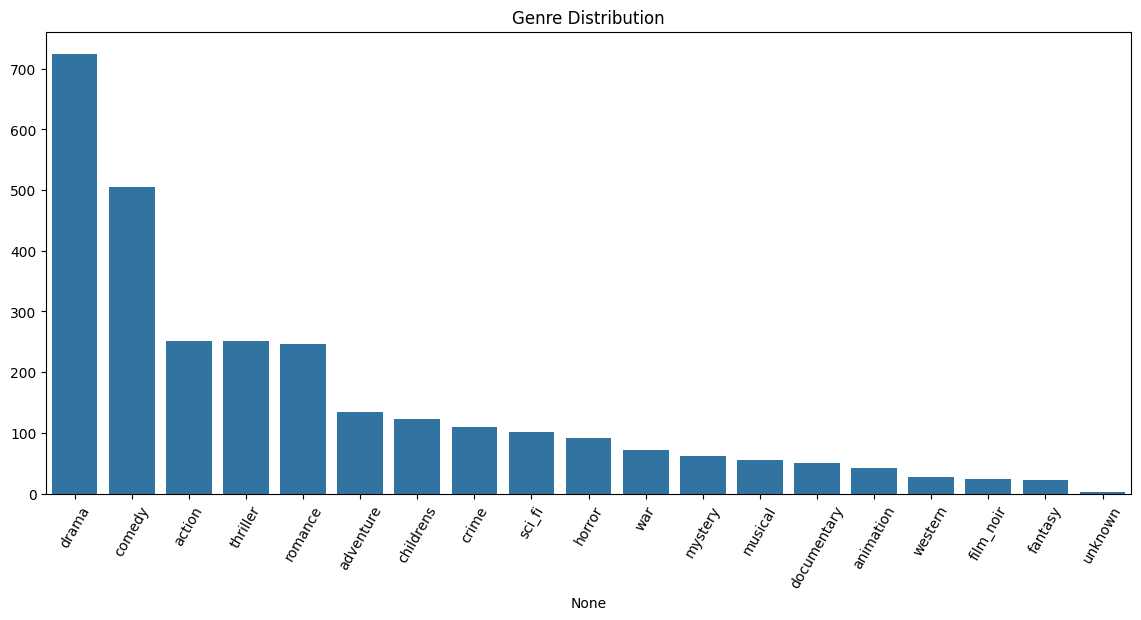

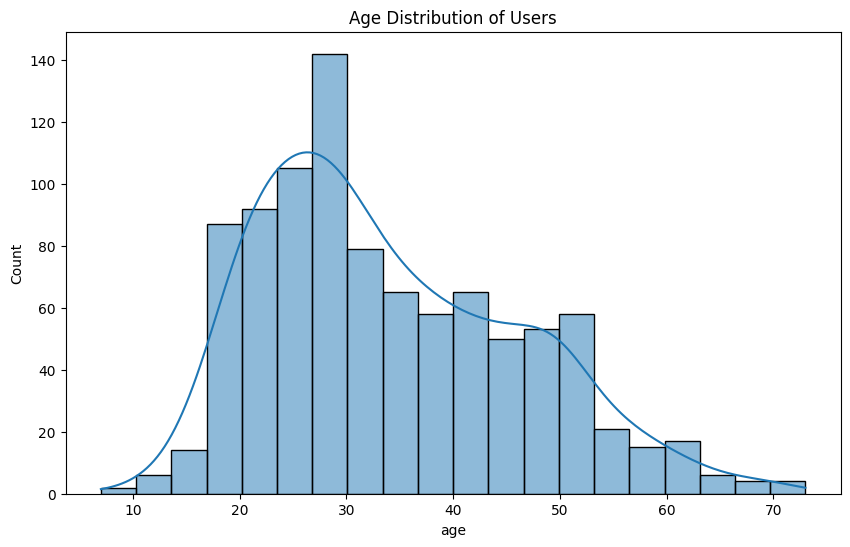

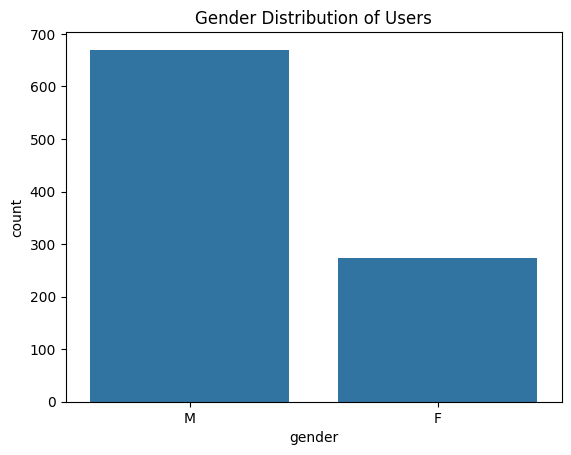

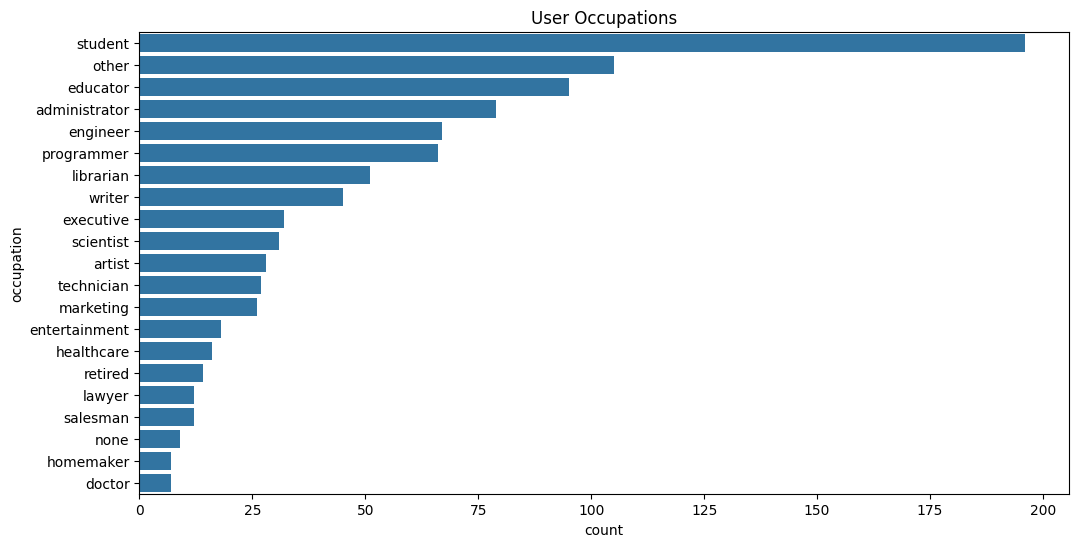

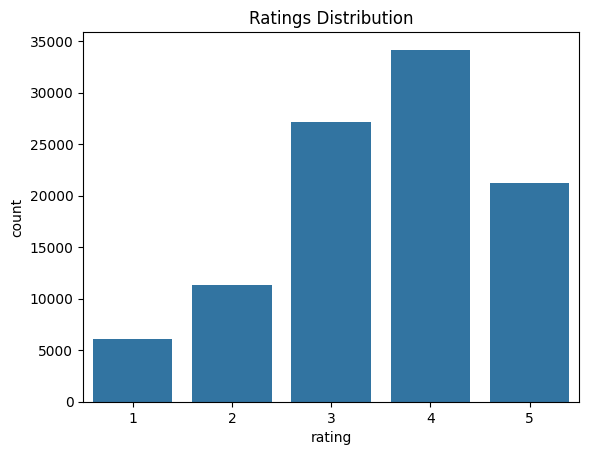

In [16]:
# Movies by decade
plt.figure(figsize=(12,6))
sns.countplot(x=(movie_df['release_date'].dt.year // 10) * 10)
plt.title("Movies Released by Decade")
plt.xlabel("Decade")
plt.ylabel("Count")
plt.show()

# Genre distribution
genre_counts = movie_df.iloc[:,5:].sum().sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=60)
plt.title("Genre Distribution")
plt.show()

# User age distribution
plt.figure(figsize=(10,6))
sns.histplot(user_df['age'], bins=20, kde=True)
plt.title("Age Distribution of Users")
plt.show()

# Gender distribution
sns.countplot(x="gender", data=user_df)
plt.title("Gender Distribution of Users")
plt.show()

# Occupations
plt.figure(figsize=(12,6))
sns.countplot(y="occupation", data=user_df, order=user_df['occupation'].value_counts().index)
plt.title("User Occupations")
plt.show()

# Ratings distribution
sns.countplot(x="rating", data=rating_df)
plt.title("Ratings Distribution")
plt.show()


## Data Preparation

We map users and movies to indices and split the dataset
into training and validation sets.


In [17]:
user2idx = {u: i for i, u in enumerate(sorted(rating_df['user_id'].unique()))}
movie2idx = {m: i for i, m in enumerate(sorted(rating_df['movie_id'].unique()))}

rating_df['userId_idx'] = rating_df['user_id'].map(user2idx)
rating_df['movieId_idx'] = rating_df['movie_id'].map(movie2idx)
rating_df['rating_float'] = rating_df['rating'].astype(np.float32)

train_df, valid_df = train_test_split(rating_df, test_size=0.2, random_state=SEED)

train_user, train_movie, train_rating = (
    train_df['userId_idx'].values,
    train_df['movieId_idx'].values,
    train_df['rating_float'].values,
)

valid_user, valid_movie, valid_rating = (
    valid_df['userId_idx'].values,
    valid_df['movieId_idx'].values,
    valid_df['rating_float'].values,
)

n_users, n_movies = len(user2idx), len(movie2idx)
print(f"Users: {n_users}, Movies: {n_movies}")


Users: 943, Movies: 1682


## 🧩 Matrix Factorization

We learn **latent embeddings** for users and movies, and
predict ratings by computing their dot product.


Epoch 1/5
79/79 - 2s - 24ms/step - loss: 13.7300 - val_loss: 13.6340
Epoch 2/5
79/79 - 0s - 4ms/step - loss: 13.0007 - val_loss: 11.1545
Epoch 3/5
79/79 - 0s - 3ms/step - loss: 7.1539 - val_loss: 3.4563
Epoch 4/5
79/79 - 0s - 4ms/step - loss: 2.2685 - val_loss: 1.6444
Epoch 5/5
79/79 - 0s - 3ms/step - loss: 1.3528 - val_loss: 1.2204


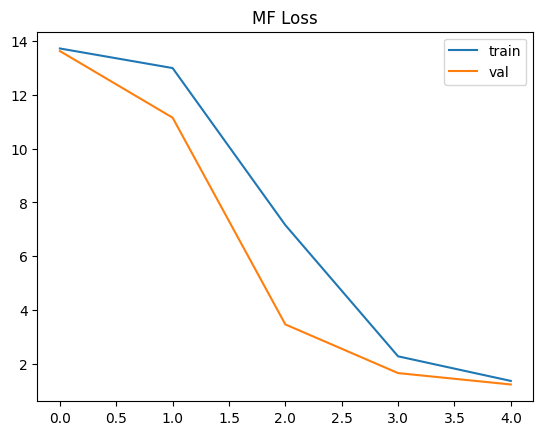

In [18]:
latent_factors = 64
u_in = Input(shape=(1,))
m_in = Input(shape=(1,))

u_emb = Embedding(n_users, latent_factors)(u_in)
m_emb = Embedding(n_movies, latent_factors)(m_in)

u_vec, m_vec = Flatten()(u_emb), Flatten()(m_emb)
dot_prod = Dot(axes=1)([u_vec, m_vec])

mf_model = Model([u_in, m_in], dot_prod)
mf_model.compile(optimizer=Adam(1e-3), loss='mse')

history = mf_model.fit(
    [train_user, train_movie], train_rating,
    validation_data=([valid_user, valid_movie], valid_rating),
    batch_size=1024, epochs=5, verbose=2
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("MF Loss")
plt.legend()
plt.show()


## 🧠 Neural Network Recommender

We extend matrix factorization by adding **dense layers**
to capture nonlinear interactions.


Epoch 1/5
79/79 - 4s - 49ms/step - loss: 11.4826 - val_loss: 8.5453
Epoch 2/5
79/79 - 2s - 30ms/step - loss: 5.4151 - val_loss: 1.8470
Epoch 3/5
79/79 - 0s - 4ms/step - loss: 1.2278 - val_loss: 0.9432
Epoch 4/5
79/79 - 0s - 4ms/step - loss: 1.0173 - val_loss: 0.9068
Epoch 5/5
79/79 - 0s - 3ms/step - loss: 0.9405 - val_loss: 0.8812


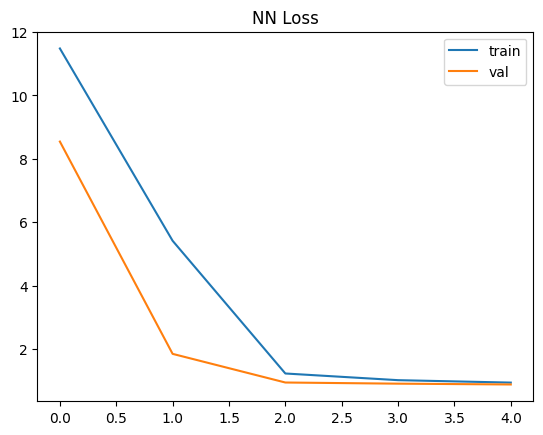

In [19]:
latent_factors_nn = 50
u_in = Input(shape=(1,))
m_in = Input(shape=(1,))

u_emb = Flatten()(Embedding(n_users, latent_factors_nn)(u_in))
m_emb = Flatten()(Embedding(n_movies, latent_factors_nn)(m_in))

interaction = Dot(axes=1)([u_emb, m_emb])
x = Dense(64, activation='relu')(interaction)
x = Dropout(0.3)(x)
out = Dense(1)(x)

nn_model = Model([u_in, m_in], out)
nn_model.compile(optimizer=Adam(1e-3), loss='mse')

history2 = nn_model.fit(
    [train_user, train_movie], train_rating,
    validation_data=([valid_user, valid_movie], valid_rating),
    batch_size=1024, epochs=5, verbose=2
)

plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.title("NN Loss")
plt.legend()
plt.show()


## 📊 Evaluation: RMSE

We measure rating prediction accuracy with **Root Mean
Squared Error (RMSE)**.


In [20]:
preds = mf_model.predict([valid_user, valid_movie]).flatten()
rmse = np.sqrt(mean_squared_error(valid_rating, preds))
print("MF RMSE:", rmse)

preds2 = nn_model.predict([valid_user, valid_movie]).flatten()
rmse2 = np.sqrt(mean_squared_error(valid_rating, preds2))
print("NN RMSE:", rmse2)

def recommend_for_user(original_user_id, top_n=5, model=mf_model):
    if original_user_id not in user2idx:
        raise ValueError("User not found")
    uidx = user2idx[original_user_id]
    movies = np.arange(n_movies)
    users = np.full_like(movies, uidx)
    preds = model.predict([users, movies], batch_size=1024).flatten()
    inv_movie = {v:k for k,v in movie2idx.items()}
    return [(inv_movie[i], preds[i]) for i in np.argsort(preds)[::-1][:top_n]]

print("Recommendations for user 1:", recommend_for_user(1))


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MF RMSE: 1.1047015004437637
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
NN RMSE: 0.9387375610583983
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Recommendations for user 1: [(np.int64(50), np.float32(5.175879)), (np.int64(302), np.float32(5.148093)), (np.int64(313), np.float32(5.134449)), (np.int64(127), np.float32(5.086799)), (np.int64(318), np.float32(5.0218635))]


In [21]:
movie_id_to_title = pd.Series(movie_df['title'].values, index=movie_df['movie_id']).to_dict()

def get_movie_title(movie_id):
    return movie_id_to_title.get(movie_id, "Unknown Movie")

# Example
recommended_ids_with_scores = recommend_for_user(1, 5)
# Extract only the movie IDs from the recommendations
recommended_ids = [movie_id for movie_id, score in recommended_ids_with_scores]
recommended_titles = [get_movie_title(mid) for mid in recommended_ids]

print("🎬 Final Recommendations for User 1:")
for title in recommended_titles:
    print("-", title)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
🎬 Final Recommendations for User 1:
- Star Wars (1977)
- L.A. Confidential (1997)
- Titanic (1997)
- Godfather, The (1972)
- Schindler's List (1993)


## 👥 User–User Collaborative Filtering

We build a **user–item rating matrix**, compute **cosine
similarity** between users, and recommend movies liked by
similar users that the target user hasn’t seen.


In [22]:
from sklearn.metrics.pairwise import cosine_similarity

# Build (users x movies) rating matrix
user_item_matrix = rating_df.pivot_table(index='user_id', columns='movie_id', values='rating')

user_item_filled = user_item_matrix.fillna(0)

# Compute cosine similarity between users
user_sim = cosine_similarity(user_item_filled)
user_sim_df = pd.DataFrame(user_sim, index=user_item_filled.index, columns=user_item_filled.index)

def recommend_user_based(target_user_id, top_n=5):
    if target_user_id not in user_item_matrix.index:
        raise ValueError("User not found")

    sims = user_sim_df[target_user_id].drop(target_user_id)
    most_similar_user = sims.idxmax()

    # Get movies rated by most similar user but unseen by target user
    target_seen = user_item_matrix.loc[target_user_id].dropna().index
    similar_user_ratings = user_item_matrix.loc[most_similar_user].dropna()
    unseen = similar_user_ratings.drop(target_seen, errors='ignore')

    # Recommend top movies based on similar user ratings
    top_recs = unseen.sort_values(ascending=False).head(top_n)
    return [(mid, rating) for mid, rating in top_recs.items()]

# Example
user_based_recs = recommend_user_based(1, top_n=5)
print("User–User CF Recommendations for User 1:")
for mid, score in user_based_recs:
    print("-", get_movie_title(mid), f"(score {score:.1f})")


User–User CF Recommendations for User 1:
- William Shakespeare's Romeo and Juliet (1996) (score 5.0)
- Bob Roberts (1992) (score 5.0)
- City of Lost Children, The (1995) (score 5.0)
- Casablanca (1942) (score 5.0)
- Wings of Desire (1987) (score 5.0)


## 🎯 Evaluation: Precision@K

We compute **Precision@K** to measure how many of the
recommended movies are actually liked (rating ≥ 4).


In [23]:
def precision_at_k(model, k=5, sample_users=100):
    precisions = []
    sampled_users = np.random.choice(list(user2idx.keys()), size=sample_users, replace=False)

    for uid in sampled_users:
        try:
            # Get recommendations
            recs = recommend_for_user(uid, top_n=k, model=model)
            recommended_ids = [mid for mid, score in recs]

            # Get movies the user actually rated highly (>=4)
            true_likes = set(rating_df[(rating_df['user_id'] == uid) & (rating_df['rating'] >= 4)]['movie_id'])

            if len(true_likes) == 0:
                continue  # skip users with no high ratings

            hits = sum([1 for mid in recommended_ids if mid in true_likes])
            precisions.append(hits / k)
        except Exception:
            continue

    return np.mean(precisions)

p_at5_mf = precision_at_k(mf_model, k=5)
p_at5_nn = precision_at_k(nn_model, k=5)

print(f"MF Precision@5: {p_at5_mf:.3f}")
print(f"NN Precision@5: {p_at5_nn:.3f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━